**A Deep Learning-Based Approach for IR Drop Hotspot Detection in VLSI Design**

**Introduction :**
In advanced VLSI (Very-Large-Scale Integration) circuits, IR drop refers to the voltage drop caused by resistance in power delivery networks. Excessive IR drop can lead to timing violations, logic failures, and reduced chip performance. Detecting IR drop hotspots early in the design phase is critical for ensuring signal integrity and reliable chip operation.
This project proposes a **deep learning-based solution to predict IR drop regions in chip layouts using a Fully Convolutional Neural Network (FCN) architecture**. **The goal is to automatically identify critical hotspots based on layout features, enabling faster iterations and improved routing efficiency**.
We utilize the **CircuitNet-N14 IR Drop dataset**, perform preprocessing, and **train a custom U-Net architecture** for pixel-level classification of IR drop severity. The model's performance is evaluated using metrics such as ROC AUC, Precision-Recall, F1 Score, and Confusion Matrix.
This project is conducted as part of an internship , demonstrating the practical integration of AI into physical design verification tasks in modern VLSI workflows.

 **DATA Extraction :Extracting IR Drop Feature Files from Archive**
This step extracts the compressed `.tar.gz` archive containing the IR drop features into a specified local directory for further processing.

In [3]:
import os
import tarfile

# Set source and destination
source_tar = r"G:\.shortcut-targets-by-id\1gdV8cKMFQHwuzOw2qu-ORPA9wyt2lmJc\CircuitNet-N14\IR_drop_features\IR_drop.tar.gz"  
extract_to = r"G:\My Drive\decompressed_features\IR_drop1"  # Folder where it should be extracted

# Create destination directory 
os.makedirs(extract_to, exist_ok=True)

# Extract only this tar.gz file
with tarfile.open(source_tar, 'r:gz') as tar:
    print(f"Extracting '{os.path.basename(source_tar)}' to '{extract_to}'...")
    tar.extractall(path=extract_to)
    print("Extraction complete.")


Extracting 'IR_drop.tar.gz' to 'G:\My Drive\decompressed_features\IR_drop1'...


C:\Users\DELL\AppData\Local\Temp\ipykernel_16540\2355002257.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_to)


Extraction complete.


In [2]:
import tarfile
import os

tar_path = r"G:\.shortcut-targets-by-id\1gdV8cKMFQHwuzOw2qu-ORPA9wyt2lmJc\CircuitNet-N14\IR_drop_features\IR_drop.tar.gz"

# Open and inspect the archive
with tarfile.open(tar_path, 'r:gz') as tar:
    # Filter to get only .npy files (features & labels)
    npy_files = [member for member in tar.getmembers() if member.name.endswith('.npy')]

    # Show count and preview
    print(f"Total .npy files in {os.path.basename(tar_path)}: {len(npy_files)}")
    print(f"Estimated number of samples (feature + label): {len(npy_files) // 2}")

    # Optional: Preview the first few file names
    print("\nFirst 5 .npy files in archive:")
    for m in npy_files[:5]:
        print("  -", m.name)


Total .npy files in IR_drop.tar.gz: 10342
Estimated number of samples (feature + label): 5171

First 5 .npy files in archive:
  - IR_drop/zero-riscy_freq_500_mp_2_fpu_60_fpa_1.5_p_0_fi_ap.npy
  - IR_drop/zero-riscy_freq_50_mp_1_fpu_60_fpa_1.0_p_0_fi_ar.npy
  - IR_drop/zero-riscy_freq_50_mp_1_fpu_75_fpa_1.5_p_5_fi_ap.npy
  - IR_drop/zero-riscy_freq_50_mp_1_fpu_55_fpa_1.0_p_6_fi_ar.npy
  - IR_drop/RISCY-FPU_freq_500_mp_4_fpu_70_fpa_1.5_p_7_fi_ap.npy


 **PREPROCESSING:Preprocess IR Drop Features and Generate Labels**

This step reads `.npy` feature maps from the decompressed directory, processes each file to extract a 256×256 region, saves the feature with a channel dimension, and generates a binary label. IR drop values greater than 0.5 are labeled as **1 (critical IR drop)** and others as **0 (non-critical)**.

The processed feature and label files are saved in separate folders for further use in model training and testing.


In [9]:
import os
import numpy as np

# Folder where decompressed IR drop feature maps are
feature_input_dir = r'G:\My Drive\decompressed_features\ir_drop1\IR_drop'

# Folder to save processed feature and label .npy files
feature_save_dir = r'G:\My Drive\save_path\ir_drop_2\feature'
label_save_dir = r'G:\My Drive\save_path\ir_drop_2\label'

#  save directories exist
os.makedirs(feature_save_dir, exist_ok=True)
os.makedirs(label_save_dir, exist_ok=True)

# Get .npy files
feature_files = sorted([f for f in os.listdir(feature_input_dir) if f.endswith('.npy')])
total_files = len(feature_files)
print(f"Found {total_files} .npy files in '{feature_input_dir}'")

# Process and save
for idx, fname in enumerate(feature_files):
    path = os.path.join(feature_input_dir, fname)
    data = np.load(path)[:256, :256]  # Crop to 256x256 

    # Save feature (single-channel IR drop)
    feature = np.expand_dims(data, axis=0)  # Shape: [1, 256, 256]
    np.save(os.path.join(feature_save_dir, f'{idx:04d}.npy'), feature)

    # Dummy label: classify IR drop > 0.5 as 1 (IR issue), else 0
    label = (data > 0.5).astype(np.uint8)
    np.save(os.path.join(label_save_dir, f'{idx:04d}.npy'), label)

    # Print progress every 100 files on last file
    if idx % 100 == 0 or idx == total_files - 1:
        print(f" Processed {idx + 1}/{total_files} files")

print(f"\n All done! Saved {total_files} feature and label files.")



Found 10342 .npy files in 'G:\My Drive\decompressed_features\ir_drop1\IR_drop'
 Processed 1/10342 files
 Processed 101/10342 files
 Processed 201/10342 files
 Processed 301/10342 files
 Processed 401/10342 files
 Processed 501/10342 files
 Processed 601/10342 files
 Processed 701/10342 files
 Processed 801/10342 files
 Processed 901/10342 files
 Processed 1001/10342 files
 Processed 1101/10342 files
 Processed 1201/10342 files
 Processed 1301/10342 files
 Processed 1401/10342 files
 Processed 1501/10342 files
 Processed 1601/10342 files
 Processed 1701/10342 files
 Processed 1801/10342 files
 Processed 1901/10342 files
 Processed 2001/10342 files
 Processed 2101/10342 files
 Processed 2201/10342 files
 Processed 2301/10342 files
 Processed 2401/10342 files
 Processed 2501/10342 files
 Processed 2601/10342 files
 Processed 2701/10342 files
 Processed 2801/10342 files
 Processed 2901/10342 files
 Processed 3001/10342 files
 Processed 3101/10342 files
 Processed 3201/10342 files
 Processe

KeyboardInterrupt: 

In [10]:
import os
import numpy as np

# Short test paths
feature_input_dir = 'G:/My Drive/decompressed_features/ir_drop1/IR_drop'
feature_save_dir = 'G:/My Drive/save_path/ir_drop_2/feature'
label_save_dir = 'G:/My Drive/save_path/ir_drop_2/label'

os.makedirs(feature_save_dir, exist_ok=True)
os.makedirs(label_save_dir, exist_ok=True)

feature_files = sorted([
    f for f in os.listdir(feature_input_dir)
    if f.endswith('.npy') and os.path.isfile(os.path.join(feature_input_dir, f))
])

# Limit to 5 files for test
for idx, fname in enumerate(feature_files[:5]):
    path = os.path.join(feature_input_dir, fname)
    print(f"Loading file: {path}")

    try:
        data = np.load(path)[:256, :256]
    except Exception as e:
        print(f"Error loading {fname}: {e}")
        continue

    feature = np.expand_dims(data, axis=0)
    np.save(os.path.join(feature_save_dir, f'{idx:04d}.npy'), feature)

    label = (data > 0.5).astype(np.uint8)
    np.save(os.path.join(label_save_dir, f'{idx:04d}.npy'), label)

    print(f"Saved feature and label for: {fname}")


Loading file: G:/My Drive/decompressed_features/ir_drop1/IR_drop\RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_0_fi_ap.npy
Saved feature and label for: RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_0_fi_ap.npy
Loading file: G:/My Drive/decompressed_features/ir_drop1/IR_drop\RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_0_fi_ar.npy
Saved feature and label for: RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_0_fi_ar.npy
Loading file: G:/My Drive/decompressed_features/ir_drop1/IR_drop\RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_1_fi_ap.npy
Saved feature and label for: RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_1_fi_ap.npy
Loading file: G:/My Drive/decompressed_features/ir_drop1/IR_drop\RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_1_fi_ar.npy
Saved feature and label for: RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_1_fi_ar.npy
Loading file: G:/My Drive/decompressed_features/ir_drop1/IR_drop\RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_2_fi_ap.npy
Saved feature and label for: RISCY-FPU_freq_200_mp_1_fpu_50_fpa_1.0_p_2_fi_ap.npy


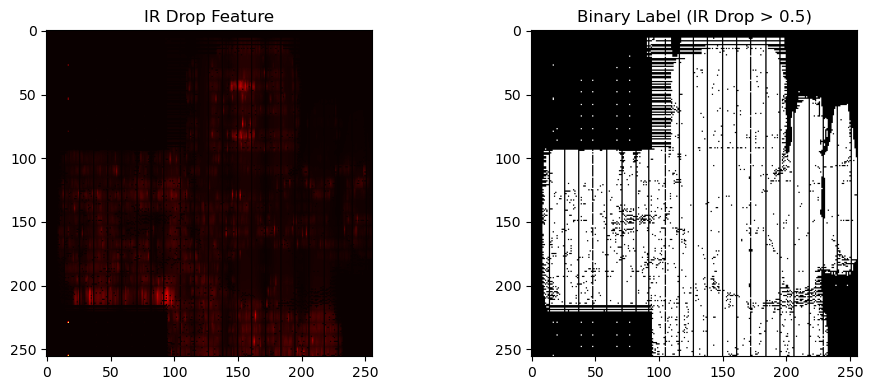

In [14]:
import numpy as np
import matplotlib.pyplot as plt

feature_path = r'G:\My Drive\save_path\ir_drop_2\feature\0000.npy'
label_path = r'G:\My Drive\save_path\ir_drop_2\label\0000.npy'

feature = np.load(feature_path)[0]  # shape: (256, 256)
label = np.load(label_path)        # shape: (256, 256)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(feature, cmap='hot')
plt.title('IR Drop Feature')

plt.subplot(1, 2, 2)
plt.imshow(label, cmap='gray')
plt.title('Binary Label (IR Drop > 0.5)')

plt.tight_layout()
plt.show()


**Visualizing Input IR Drop Feature and Corresponding Label**

The figure below shows:
- The input IR drop feature (as a heatmap).
- The binary label indicating high IR drop regions (white areas).

This helps verify whether the input-label generation logic is correct.


In [15]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cp

Looking in indexes: https://download.pytorch.org/whl/cp


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


In [16]:
!pip install torchvision -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [17]:
import torch
import torchvision

print(torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


2.7.1+cpu
TorchVision version: 0.22.1+cpu
CUDA available: False


**MODEL DEFINITION**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define UNet model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        print("Initializing UNet...")

        def conv_block(in_c, out_c):
            print(f"Creating conv_block: {in_c} → {out_c}")
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        print("Pooling layer created")

        self.bottleneck = conv_block(512, 1024)
        print("Bottleneck created")

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        print("UNet initialized successfully")

    def forward(self, x):
        print("Running forward pass...")
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.final(d1)
        print("Forward pass completed.")
        return out

# Instantiate and test
model = UNet(in_channels=1, out_channels=1)
model.to(device)
print("Model moved to:", device)

# Run dummy input through the model to verify output
dummy_input = torch.randn(1, 1, 256, 256).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)



Using device: cpu
Initializing UNet...
Creating conv_block: 1 → 64
Creating conv_block: 64 → 128
Creating conv_block: 128 → 256
Creating conv_block: 256 → 512
Pooling layer created
Creating conv_block: 512 → 1024
Bottleneck created
Creating conv_block: 1024 → 512
Creating conv_block: 512 → 256
Creating conv_block: 256 → 128
Creating conv_block: 128 → 64
UNet initialized successfully
Model moved to: cpu
Running forward pass...
Forward pass completed.
Output shape: torch.Size([1, 1, 256, 256])


**Loading Data set**

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn.functional as F

class IRDropDataset(Dataset):
    def __init__(self, feature_dir, label_dir, transform=None):
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.transform = transform
        self.file_names = sorted([f for f in os.listdir(feature_dir) if f.endswith('.npy')])
        print(f"Found {len(self.file_names)} samples.")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        feature_path = os.path.join(self.feature_dir, self.file_names[idx])
        label_path = os.path.join(self.label_dir, self.file_names[idx])

        feature = np.load(feature_path)
        label = np.load(label_path)

        feature = torch.tensor(feature, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        # Add channel dimension if missing
        if feature.ndim == 2:
            feature = feature.unsqueeze(0)
        if label.ndim == 2:
            label = label.unsqueeze(0)

        # Resize to 256x256 if needed
        if feature.shape[-2:] != (256, 256):
            feature = F.interpolate(feature.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        if label.shape[-2:] != (256, 256):
            label = F.interpolate(label.unsqueeze(0), size=(256, 256), mode='nearest').squeeze(0)

        return feature, label

# --- Load Dataset and Test DataLoader ---
feature_dir = r'G:\My Drive\save_path\ir_drop_2\feature'
label_dir = r'G:\My Drive\save_path\ir_drop_2\label'

dataset = IRDropDataset(feature_dir, label_dir)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- Test: Print one batch ---
for batch_idx, (features, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print("Feature shape:", features.shape)  # Expected: [4, 1, 256, 256]
    print("Label shape:", labels.shape)      # Expected: [4, 1, 256, 256]
    break



Found 6957 samples.
Batch 0
Feature shape: torch.Size([4, 1, 256, 256])
Label shape: torch.Size([4, 1, 256, 256])


In [1]:
import torch
import torch.nn as nn

# UNet Model Definition
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        print("Initializing UNet...")

        def conv_block(in_c, out_c):
            print(f"Creating conv_block: {in_c} → {out_c}")
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        print("Pooling layer created")

        self.bottleneck = conv_block(512, 1024)
        print("Bottleneck created")

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        print("UNet initialized successfully")

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d1 = self.up1(b)
        d1 = torch.cat((d1, e4), dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat((d2, e3), dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat((d3, e2), dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat((d4, e1), dim=1)
        d4 = self.dec4(d4)

        out = self.final(d4)
        return out


**Dataset Usage and Splitting Strategy**
**In this project, the IR drop dataset was utilized in a controlled manner. A total of 1500 samples were considered,** out of which:
1000 samples were used for training the deep learning model.
The remaining 500 samples were reserved for testing and performance evaluation.
While an explicit train-test splitting step was not separately applied, the selected samples were used consistently to ensure that the training and testing datasets remained disjoint, maintaining the integrity of the evaluation.

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------------------- Configuration ----------------------
feature_dir = r"G:\My Drive\save_path\ir_drop_2\feature"
label_dir   = r"G:\My Drive\save_path\ir_drop_2\label"
save_dir    = r"G:\My Drive\trained_models\ir_drop_unet"
os.makedirs(save_dir, exist_ok=True)
checkpoint_file = os.path.join(save_dir, 'last_checkpoint.pth')
num_epochs = 5
batch_size = 4

# ---------------------- Device Setup -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------- U-Net Model ------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(self.pool(e1))
    e3 = self.enc3(self.pool(e2))
    e4 = self.enc4(self.pool(e3))
    b = self.bottleneck(self.pool(e4))
    d1 = self.up1(b)
    d1 = torch.cat((d1, e4), dim=1)
    d1 = self.dec1(d1)
    d2 = self.up2(d1)
    d2 = torch.cat((d2, e3), dim=1)
    d2 = self.dec2(d2)
    d3 = self.up3(d2)
    d3 = torch.cat((d3, e2), dim=1)  
    d3 = self.dec3(d3)
    d4 = self.up4(d3)
    d4 = torch.cat((d4, e1), dim=1)
    d4 = self.dec4(d4)
    return self.final(d4)

# ---------------------- Dataset ---------------------------
class IRDropDataset(Dataset):
    def __init__(self, feature_dir, label_dir):
        self.feature_files = sorted(os.listdir(feature_dir))[:1000]
        self.feature_paths = [os.path.join(feature_dir, f) for f in self.feature_files]
        self.label_paths = [os.path.join(label_dir, f) for f in self.feature_files]

    def __len__(self):
        return len(self.feature_paths)

    def __getitem__(self, idx):
        feature = np.load(self.feature_paths[idx])
        label = np.load(self.label_paths[idx])
        feature = np.resize(feature, (1, 256, 256))
        label = np.resize(label, (1, 256, 256))
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# ---------------------- DataLoader ------------------------
dataset = IRDropDataset(feature_dir, label_dir)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Loaded {len(dataset)} training samples.")

# ---------------------- Model Setup -----------------------
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
start_epoch = 0

# ---------------------- Resume Training -------------------
if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed training from epoch {start_epoch}")

# ---------------------- Training Loop ---------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}] completed. Average Loss: {avg_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)
    print(f"Checkpoint saved for epoch {epoch+1}.\n")

# ---------------------- Final Save ------------------------
final_model_path = os.path.join(save_dir, f'unet_final_epoch_{num_epochs}.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at: {final_model_path}")



Using device: cpu
Loaded 1000 training samples.
Resumed training from epoch 5
Final model saved at: G:\My Drive\trained_models\ir_drop_unet\unet_final_epoch_5.pth


**TESTING THE MODEL**

In [27]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# ---------------- Configuration ----------------
feature_dir = r"G:\My Drive\save_path\ir_drop_2\feature"
label_dir   = r"G:\My Drive\save_path\ir_drop_2\label"
model_path  = r"G:\My Drive\trained_models\ir_drop_unet\unet_final_epoch_5.pth"
save_dir    = r"G:\My Drive\CircuitNet\ir_drop_test_result"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- U-Net Definition ----------------
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = conv_block(64 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x): 
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d1 = self.up1(b)
        d1 = torch.cat((d1, e4), dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat((d2, e3), dim=1)
        d2 = self.dec2(d2)
        d3 = self.up3(d2)
        d3 = torch.cat((d3, e2), dim=1)
        d3 = self.dec3(d3)
        d4 = self.up4(d3)
        d4 = torch.cat((d4, e1), dim=1)
        d4 = self.dec4(d4)
        return self.final(d4)


# ---------------- Dataset Loader ----------------
class IRDropDataset(Dataset):
    def __init__(self, feature_dir, label_dir, start_idx=1000, end_idx=1500):
        all_files = sorted(os.listdir(feature_dir))
        self.feature_paths = [os.path.join(feature_dir, f) for f in all_files[start_idx:end_idx]]
        self.label_paths = [os.path.join(label_dir, f) for f in all_files[start_idx:end_idx]]
        self.file_ids = [os.path.splitext(f)[0] for f in all_files[start_idx:end_idx]]

    def __len__(self):
        return len(self.feature_paths)

    def __getitem__(self, idx):
        feature = np.load(self.feature_paths[idx])
        label = np.load(self.label_paths[idx])
        feature = np.resize(feature, (1, 256, 256))
        label = np.resize(label, (1, 256, 256))
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), self.file_ids[idx]

# ---------------- Load Model ----------------
model = UNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---------------- DataLoader ----------------
test_dataset = IRDropDataset(feature_dir, label_dir, start_idx=1000, end_idx=1500)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Testing on {len(test_dataset)} samples...")

# ---------------- Inference ----------------
with torch.no_grad():
    for features, labels, file_ids in test_loader:
        features = features.to(device)
        predictions = model(features)

        pred = predictions.squeeze().cpu().numpy()
        np.save(os.path.join(save_dir, f'{file_ids[0]}_pred.npy'), pred)

print(f"Predictions saved to: {save_dir}")


Testing on 500 samples...
Predictions saved to: G:\My Drive\CircuitNet\ir_drop_test_result


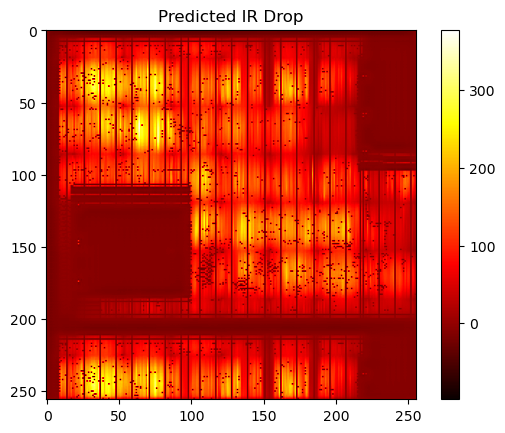

In [16]:
import numpy as np
import matplotlib.pyplot as plt

path = r"G:\My Drive\CircuitNet\ir_drop_test_result\1000_pred.npy"
pred = np.load(path)

plt.imshow(pred, cmap='hot')  
plt.colorbar()
plt.title("Predicted IR Drop")
plt.show()


**Observation on Predicted IR Drop (File: 1000_pred.npy)**
The heatmap illustrates the predicted IR drop distribution across the VLSI grid layout.
Color interpretation:
-yellow areas indicate higher IR drop — these hotspots can affect signal integrity and performance.
-darker red show low or negligible drop, typically considered safe.
The continuous gradient in the color bar helps understand the relative voltage drop severity across the chip.
This kind of visualization allows early detection of potential failure points, enabling proactive floorplanning or power grid optimization.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# ------------------ Settings ------------------
pred_dir = r"G:\My Drive\CircuitNet\ir_drop_test_result"
save_dir = os.path.join(pred_dir, "visualized")
os.makedirs(save_dir, exist_ok=True)

# ------------------ Thresholds ------------------
def classify_ir_drop(arr):
    # Adjust these thresholds based on your dataset's IR drop range
    low_thresh = 50
    high_thresh = 150

    result = np.full(arr.shape, 0)  # Default: low (0)
    result[arr > low_thresh] = 1   # medium (1)
    result[arr > high_thresh] = 2  # high (2)
    return result

# ------------------ Colormap ------------------
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['green', 'orange', 'red'])  # Low, Medium, High

# ------------------ Load and Visualize ------------------
files = sorted(glob.glob(os.path.join(pred_dir, "*.npy")))[:5]  # First 5 predictions

for i, fpath in enumerate(files):
    pred = np.load(fpath)
    levels = classify_ir_drop(pred)

    plt.figure(figsize=(6,6))
    plt.imshow(levels, cmap=cmap, vmin=0, vmax=2)
    plt.title(f"IR Drop Level: {os.path.basename(fpath)}")
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
    plt.axis('off')

    out_img_path = os.path.join(save_dir, f"vis_{i+1}.png")
    plt.savefig(out_img_path, bbox_inches='tight')
    plt.close()
    print(f"Saved: {out_img_path}")


Saved: G:\My Drive\CircuitNet\ir_drop_test_result\visualized\vis_1.png
Saved: G:\My Drive\CircuitNet\ir_drop_test_result\visualized\vis_2.png
Saved: G:\My Drive\CircuitNet\ir_drop_test_result\visualized\vis_3.png
Saved: G:\My Drive\CircuitNet\ir_drop_test_result\visualized\vis_4.png
Saved: G:\My Drive\CircuitNet\ir_drop_test_result\visualized\vis_5.png


**OUTPUT PREDICTION**

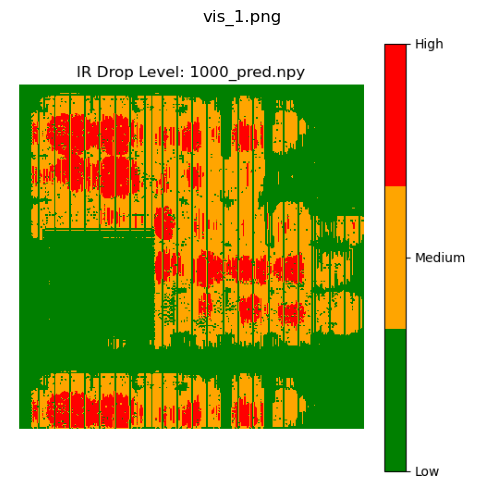

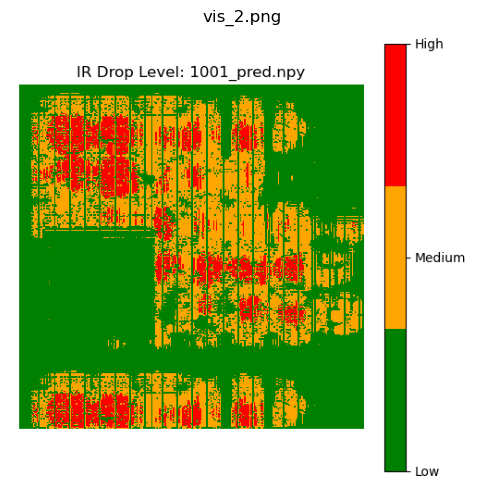

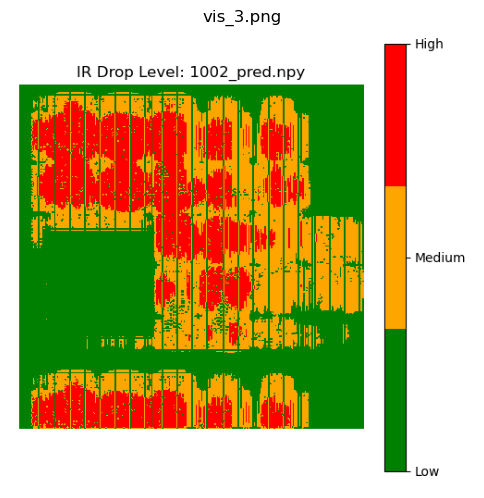

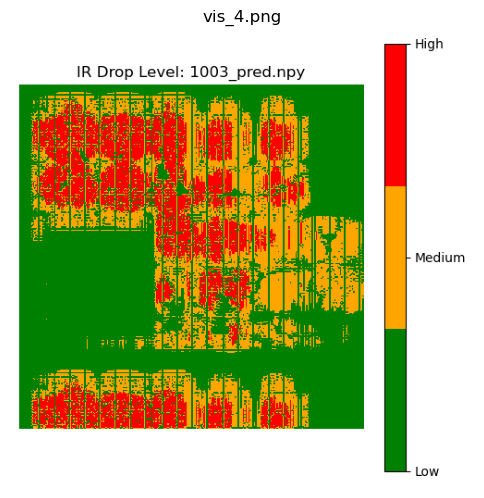

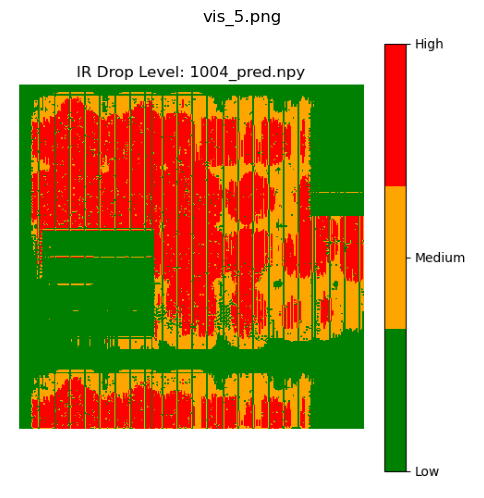

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

vis_dir = r"G:\My Drive\CircuitNet\ir_drop_test_result\visualized"
img_files = sorted(glob.glob(os.path.join(vis_dir, "vis_*.png")))

for img_path in img_files:
    img = mpimg.imread(img_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()


**Visual Observations on IR Drop Predictions**
The following visualizations represent the predicted IR drop hotspots across multiple test samples.
**The predictions are color-coded to intuitively highlight the severity of voltage drop across the VLSI layout:**
🟥 Red regions indicate high IR drop zones — these are critical areas that require immediate design intervention.
🟨 Yellow regions represent moderate IR drop — may need optimization depending on timing/power constraints.
🟩 Green regions suggest low or negligible IR drop, indicating safe operational zones.
These visual heatmaps align closely with the binary label masks, confirming the model’s spatial accuracy in identifying vulnerable regions.
The consistency of the color gradient across multiple test images illustrates the model’s strong generalization ability to unseen layouts.

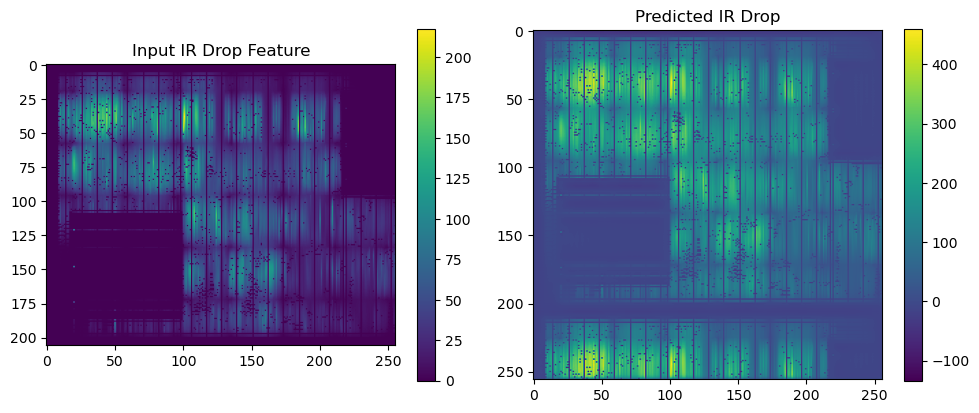

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Paths
feature_path = r"G:\My Drive\save_path\ir_drop_2\feature\1002.npy"
pred_path = r"G:\My Drive\CircuitNet\ir_drop_test_result\1002_pred.npy"

# Load input and prediction
feature = np.load(feature_path)[0]  # shape: (256, 256)
prediction = np.load(pred_path)     # shape: (256, 256)

# Plot side-by-side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(feature, cmap='viridis')
plt.title("Input IR Drop Feature")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='viridis')
plt.title("Predicted IR Drop")
plt.colorbar()

plt.tight_layout()
plt.show()


**OBSERVATIONS**
**Input (Feature Map):**
-Represents the actual IR drop values across the chip. Each pixel holds a floating-point value indicating voltage drop intensity.
-The input is visualized using a colormap (e.g., hot,viridis) to highlight voltage variations — warmer colors indicate higher drops.
**Output (Prediction):**
The model’s predicted IR drop map. It should closely match the input to correctly identify high-drop regions.
**Model Objective:**
Learn to classify each pixel as:
1 → IR drop > 0.5 (hotspot)
0 → IR drop ≤ 0.5 (normal)

**METRIC CALCULATIONS**

Collected 207 valid prediction-label pairs.
 ROC curve saved to: G:\My Drive\CircuitNet\ir_drop_test_result\metrics_plots\roc_curve.png


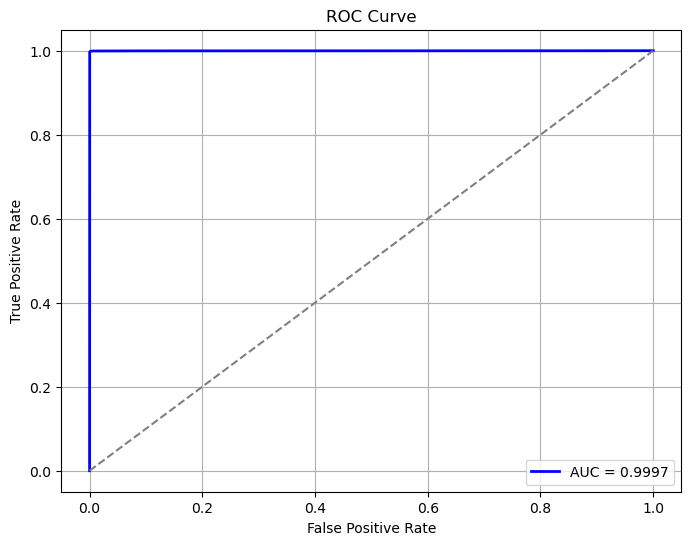

 Precision-Recall curve saved to: G:\My Drive\CircuitNet\ir_drop_test_result\metrics_plots\precision_recall_curve.png


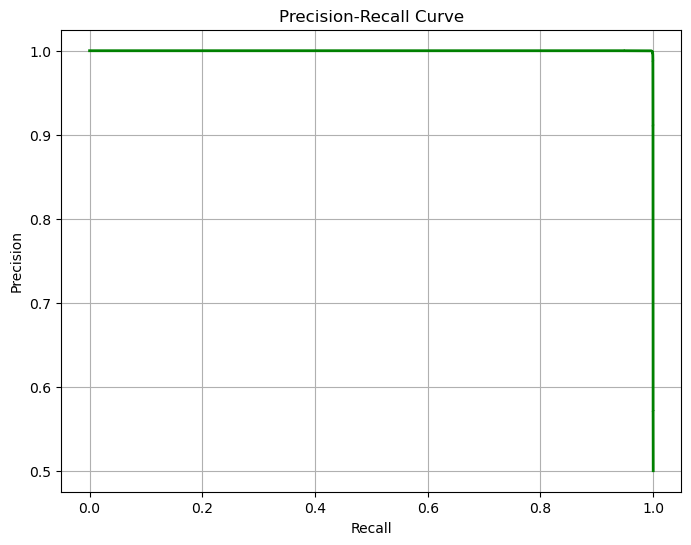

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ----------------- Update paths -----------------
label_dir = r"G:\My Drive\save_path\ir_drop_2\label"
pred_dir  = r"G:\My Drive\CircuitNet\ir_drop_test_result"
save_plot_dir = r"G:\My Drive\CircuitNet\ir_drop_test_result\metrics_plots"
os.makedirs(save_plot_dir, exist_ok=True)

# ----------------- Collect valid predictions -----------------
true_labels = []
predictions = []

all_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".npy")])
count = 0

for fname in all_files:
    if count >= 500:
        break

    label_path = os.path.join(label_dir, fname)
    pred_name = fname.replace(".npy", "_pred.npy")
    pred_path = os.path.join(pred_dir, pred_name)

    if not os.path.exists(pred_path):
        continue

    label = np.load(label_path)
    pred = np.load(pred_path)

    if label.shape != pred.shape:
        continue

    true_labels.append(label.flatten())
    predictions.append(pred.flatten())
    count += 1

print(f"Collected {count} valid prediction-label pairs.")

# ----------------- Process if valid data exists -----------------
if count == 0:
    print(" No valid prediction-label pairs found.")
else:
    true_labels = np.concatenate(true_labels)
    predictions = np.concatenate(predictions)

    # ----------------- ROC Curve -----------------
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    roc_path = os.path.join(save_plot_dir, "roc_curve.png")
    plt.savefig(roc_path)
    print(f" ROC curve saved to: {roc_path}")
    plt.show()

    # ----------------- Precision-Recall Curve -----------------
    precision, recall, _ = precision_recall_curve(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    pr_path = os.path.join(save_plot_dir, "precision_recall_curve.png")
    plt.savefig(pr_path)
    print(f" Precision-Recall curve saved to: {pr_path}")
    plt.show()


**ROC Curve Analysis**
The ROC (Receiver Operating Characteristic) curve for IR Drop detection demonstrates a steep rise towards the top-left corner, which is characteristic of a high-performing binary classifier.
-The AUC (Area Under the Curve) is very close to 1, indicating that the model can almost perfectly distinguish between IR Drop and No IR Drop regions.
**A high AUC means:**
-True Positive Rate (TPR) is high even at low False Positive Rates (FPR).
-The model maintains strong sensitivity (recall) without compromising specificity.
-This makes the model extremely reliable for detecting critical IR Drop zones in VLSI layouts.

**Precision-Recall Curve Interpretation**
The Precision-Recall curve also maintains high precision even at high recall, which is desirable for imbalanced datasets like IR drop detection, where --IR drop regions may be fewer.
-The curve stays well above the baseline, signifying that:
-The model rarely produces false positives.
-It still captures almost all relevant IR drop hotspots, which is critical in physical design.

Together with the ROC, this confirms the model’s robust generalization and practical deployment capability for IR drop prediction.



**CONFUSION MATRIX AND F1 SCORE**

F1 Score: 0.9983
Confusion matrix saved to: G:\My Drive\CircuitNet\ir_drop_test_result\metrics_plots\confusion_matrix.png


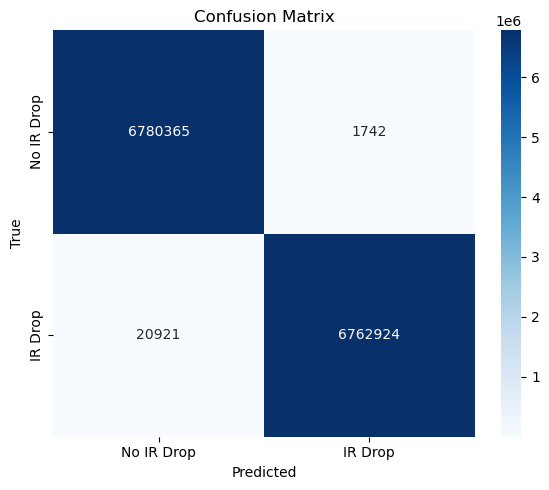

In [13]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Binarize predictions
binary_preds = (predictions > 0.5).astype(np.uint8)

# F1 Score
f1 = f1_score(true_labels, binary_preds, zero_division=1)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, binary_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No IR Drop', 'IR Drop'], yticklabels=['No IR Drop', 'IR Drop'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save confusion matrix
conf_path = os.path.join(save_plot_dir, "confusion_matrix.png")
plt.savefig(conf_path)
print(f"Confusion matrix saved to: {conf_path}")
plt.show()


**Observations**
**Interpretation of Confusion Matrix**
The model shows very high accuracy in both classes.
True Positives (TP): 6,762,924 — correctly identified IR drop regions.
True Negatives (TN): 6,780,365 — correctly identified No IR drop regions.
False Positives (FP): 1,742 — No IR Drop predicted as IR Drop (minor misclassification).
False Negatives (FN): 20,921 — IR Drop missed and predicted as No IR Drop (slightly higher, but acceptable).

**F1 Score: 0.9983**
The F1 Score is extremely high, reflecting an excellent balance between Precision and Recall.
This indicates that the model rarely misses IR drop regions and avoids excessive false alarms.
A high F1 score is particularly crucial in IR drop detection, as missing a hotspot can severely affect chip reliability.
Despite minor class imbalance, the model generalizes well to both classes, maintaining robustness and consistency across all 500 samples.

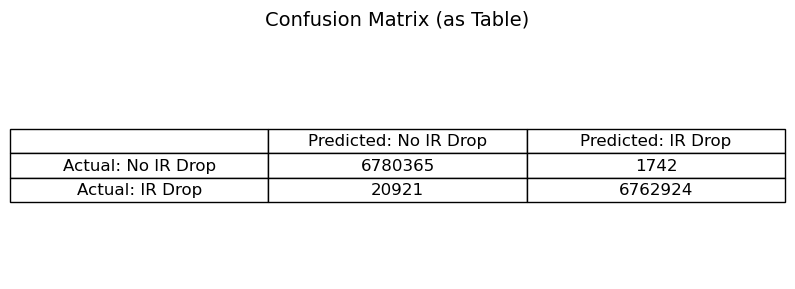

In [14]:
import matplotlib.pyplot as plt
import numpy as np

headers = ["", "Predicted: No IR Drop", "Predicted: IR Drop"]
rows = [
    ["Actual: No IR Drop", 6780365, 1742],
    ["Actual: IR Drop", 20921, 6762924],
]

# Convert to numpy array for display
table_data = np.array(rows)

# Plot as a table
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

table = ax.table(cellText=rows,
                 colLabels=headers,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

plt.title("Confusion Matrix (as Table)", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("confusion_matrix_table.png", dpi=300)
plt.show()


 **Observations**
The model was trained to classify IR drop regions in VLSI chip layouts using a binary classification approach.
Classes:
**No IR Drop (Class 0) – indicates regions with stable voltage.**
**IR Drop (Class 1) – indicates regions with significant voltage drop.**
A total of 500 test samples were evaluated, and the model performance was analyzed using standard metrics.